Suppose $x(t)$ where $x(0) = 0$ is a stochastic signal whose ensemble average $\bar x(t)$ strictly increases over time, e.g. the center of a propagating wave, or the position of a car unable to reverse. In neuroscience it could be the location in a songbird song.

We write this as

$\dot x = f(x) + \eta$

where $f(x) \geq 0$ and $\eta$ is noise.

Because of this noise, different samples of $x(t)$ will diverge from one another over time, regardless of our choice of $f$.

Given a target sequence $\bar x(t)$ that is solution to $\dot x = f(x)$, our goal is to construct a control signal $a(x)$ potentially distributed in space but modulated only by a time-varying scalar function $b(t)$ such that if we re-define

$\dot x = f(x) + \eta + a(x)b(t)$

then 

$$\left<\frac{1}{T} \int_0^T dt (x(t) - \bar x(t))\right>_\eta$$

is minimized.

Ideally, for very long signals, the error between $x(t)$ and $\bar x(t)$ should be bounded:

$$\lim\limits_{T\rightarrow \infty} \left<\frac{1}{T} \int_0^T dt (x(t) - \bar x(t))\right>_\eta < C.$$

We first note that $a(x)b(t) = a(x)$ i.e. not a function of $t$ does not work, since this can then be absorbed into $f$, leaving us with the same fundamental problem. Nor does $a(x)b(t) = b(t)$ work, since this will not be able to cancel the fluctuations given by stochastic $\eta$. How could the product $a(x)b(t)$ overcome this?

To gain intuition we first consider constant $f(x) = h$, i.e $\dot x = h + \eta$ with $\eta$ Gaussian white noise. We plot $\bar x(t)$ below and a few instantiations of $x(t)$ and their differences to $\bar x(t)$.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size, set_color


D = 1000
N_TR = 10

DT = .5
T = np.arange(0, D, DT)

H = 1.
X_BAR = H*T  # mean x

DX = .1
X = np.arange(0, 2*X_BAR[-1], DX) - X_BAR[-1]/2


def run(a=None, b=None, sgm=0, seed=None):
    """
    Sample x(t).
    
    seed: int
    a: scalar func takes x as input
    b: 1-d array same size as t
    """
    
    if a is None:
        a = np.zeros(len(X))
    if b is None:
        b = np.zeros(len(T))
        
    # compute discrete noise std size from dt
    noise_std = sgm / np.sqrt(DT)
    
    x = np.nan*np.zeros(len(T))
    x[0] = 0
    
    np.random.seed(seed)
    
    for ct_, t_ in enumerate(T[1:], 1):
        
        # idx of last x to get nearest a(x)
        ix = int(round(np.clip(x[ct_-1] - X[0], X[0], X[-1])/DX))  
        
        # update x
        dx_dt = H + np.random.randn()*noise_std + a[ix]*b[ct_]

        x[ct_] = x[ct_-1] + dx_dt * DT
        
    return x


def rms_err(xs):
    err = np.array(xs - np.tile(X_BAR[:, None], (1, xs.shape[1])))
    return np.sqrt(np.mean(err**2, 0)).mean()


def plot_ab(a, b, xs=None):
    
    axs = list(plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)[1])
        
    # plot unmodulated a(x)
    a_mat = np.tile(a[:, None], (1, len(T)))
    lb_a = a_mat.min()
    ub_a = a_mat.max()
    axs[0].imshow(a_mat, origin='lower', vmin=lb_a, vmax=ub_a, cmap='PiYG', extent=(T[0], T[-1], X[0], X[-1]))
    axs[0].plot(T, X_BAR, lw=2, c='k')
    axs[0].set_ylim(X_BAR[0], X_BAR[-1])
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title('a(x)')
    
    # plot a(x)b(t)
    ab_mat = a[:, None] @ b[None, :]
    lb_ab = ab_mat.min()
    ub_ab = ab_mat.max()
    axs[1].imshow(ab_mat, origin='lower', vmin=lb_ab, vmax=ub_ab, cmap='PiYG', extent=(T[0], T[-1], X[0], X[-1]))
    axs[1].plot(T, X_BAR, lw=2, c='k')
    axs[1].set_ylim(X_BAR[0], X_BAR[-1])
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title('a(x)b(t)')
    
    if xs is not None:
        for ax in axs[:2]:
            ax.plot(T, xs, c='k')
            
    # plot a(x), b(t) individually
    axs[2].plot(T, b, c='k', lw=2)  # b
    axs[2].set_xlabel('t')
    axs[2].set_ylabel('b(t)')
    set_color(axs[2], 'k')
    
    # recale X to plot on same x-axis as T, so max x_bar matches max t
    x_rescaled = X * (T.max()/ X_BAR.max())
    ax_3 = axs[2].twinx()
    ax_3.plot(x_rescaled, a, c='b')
    ax_3.set_xlim(T[0], T[-1])
    ax_3.set_ylabel('a(x)')
    set_color(ax_3, 'b')
    
    ax_4 = ax_3.twiny()
    ax_4.set_xlim(X_BAR[0], X_BAR[-1])
    ax_4.set_xlabel('x')
    set_color(ax_4, 'b')

    axs.extend([ax_3, ax_4])
    
    for ax in axs:
        set_font_size(ax, 16)
        

def plot_err(xs, y_lim=None):
    fig, ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)
    ax.plot(T, xs - np.tile(X_BAR[:, None], (1, xs.shape[1])), lw=2)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.set_xlabel('t')
    ax.set_ylabel(r'$x - \bar{x}$')
    
    # calc rms error
    
    ax.set_title('Mean error = {0:.4f}'.format(rms_err(xs)))
    
    set_font_size(ax, 16)

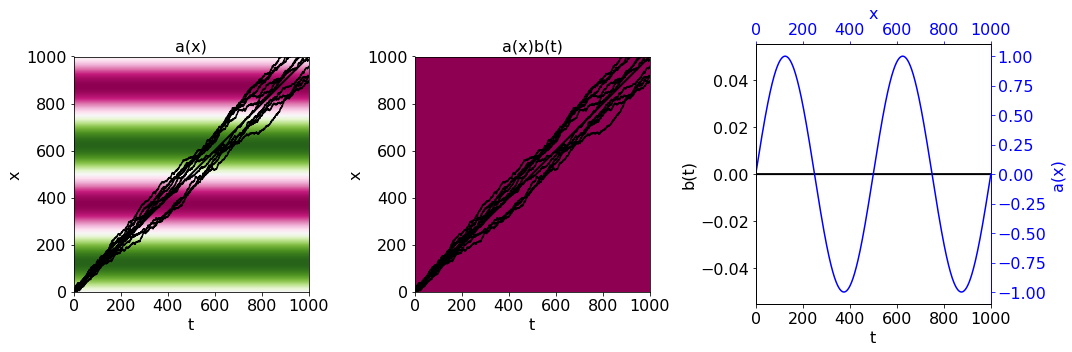

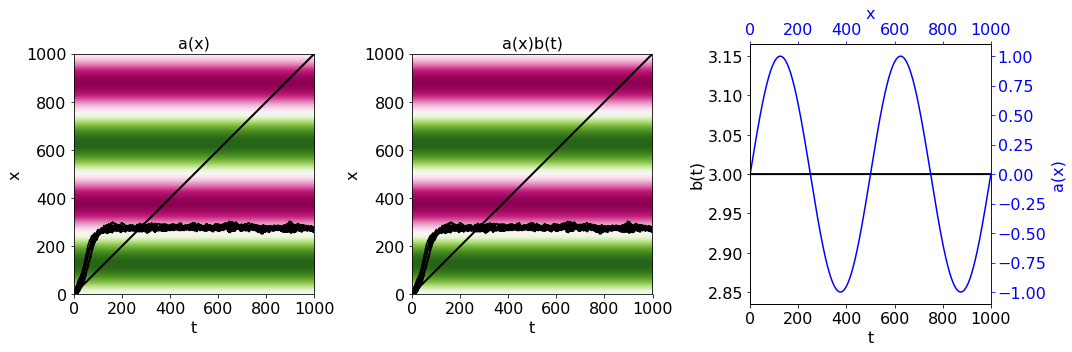

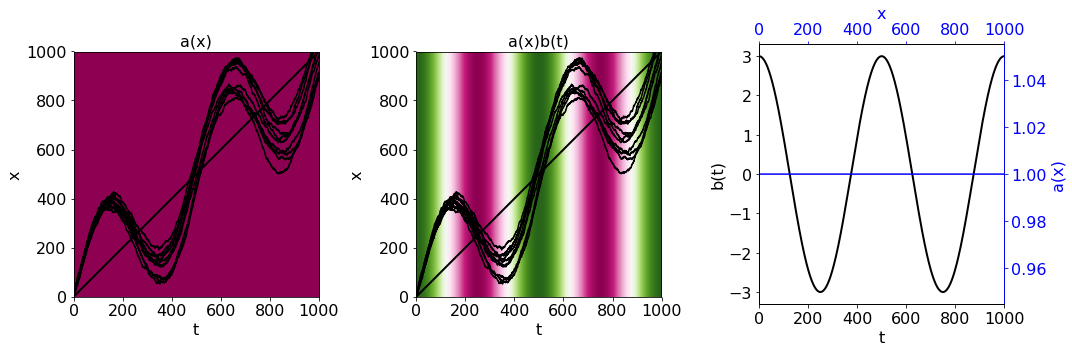

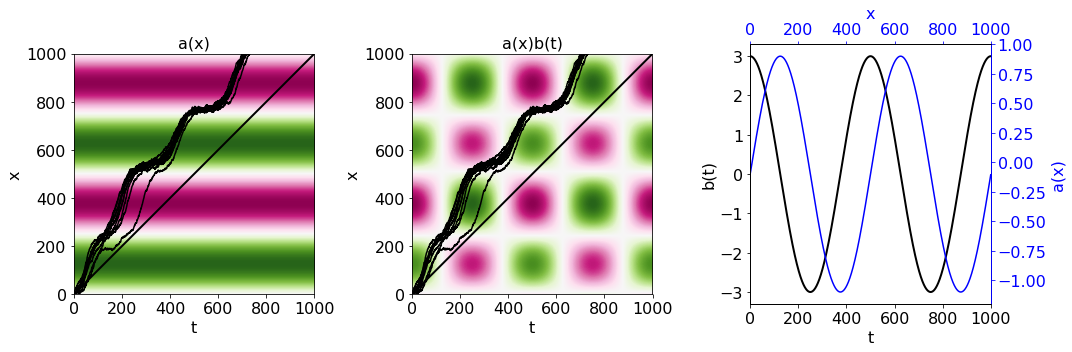

In [2]:
# test plot func
a = np.sin(2*np.pi*X / 500)
b = np.zeros(len(T))

xs = np.transpose([run(a, b, 2, seed=i) for i in range(N_TR)])

plot_ab(a, b, xs);

# test plot func
a = np.sin(2*np.pi*X / 500)
b = 3*np.ones(len(T))

xs = np.transpose([run(a, b, 2, seed=i) for i in range(N_TR)])

plot_ab(a, b, xs);

# test plot func
a = np.ones(len(X))
b = 3*np.cos(2*np.pi*T / 500)

xs = np.transpose([run(a, b, 2, seed=i) for i in range(N_TR)])

plot_ab(a, b, xs);

# test plot func
a = np.sin(2*np.pi*X / 500) - .1
b = 3*np.cos(2*np.pi*T / 500)

xs = np.transpose([run(a, b, 2, seed=i) for i in range(N_TR)])

plot_ab(a, b, xs);

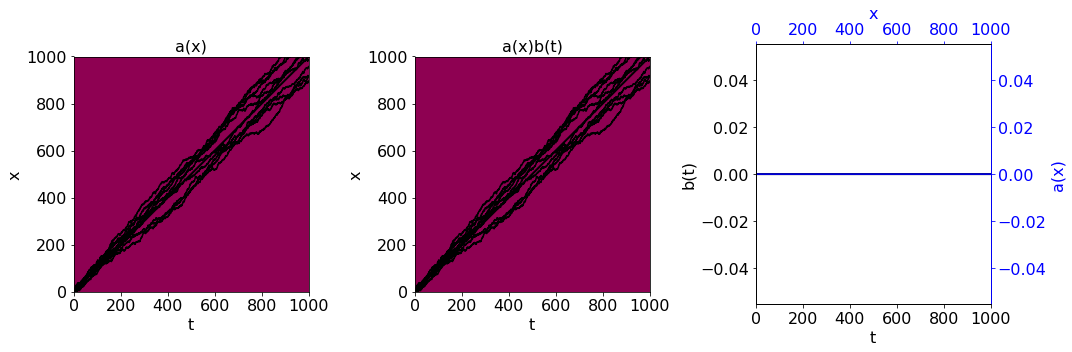

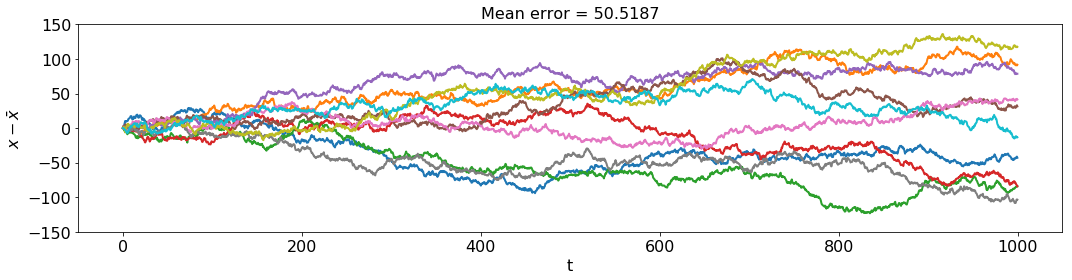

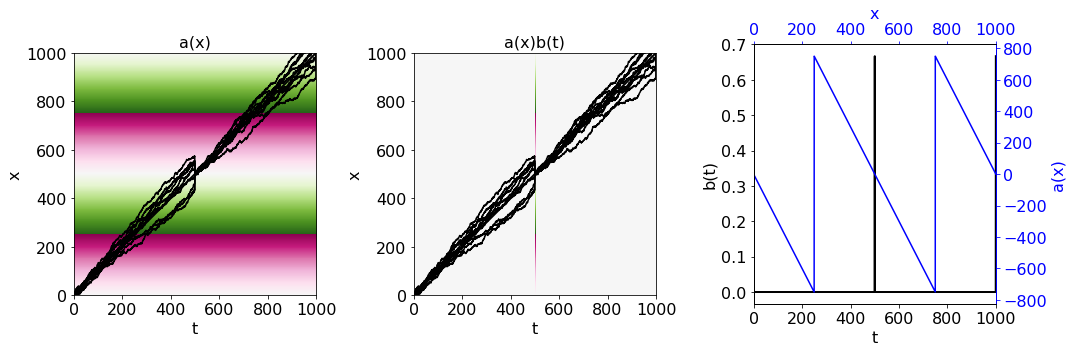

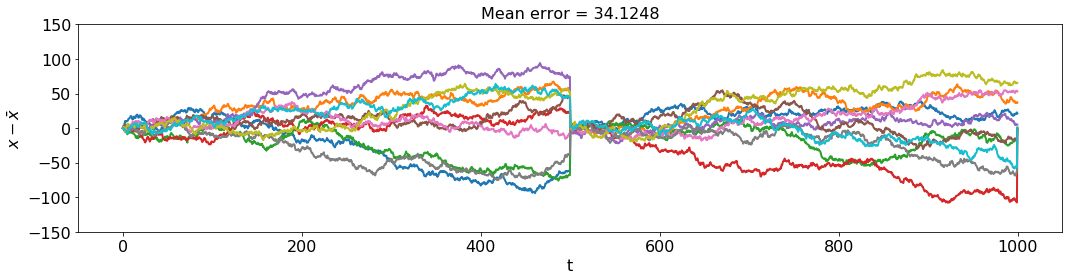

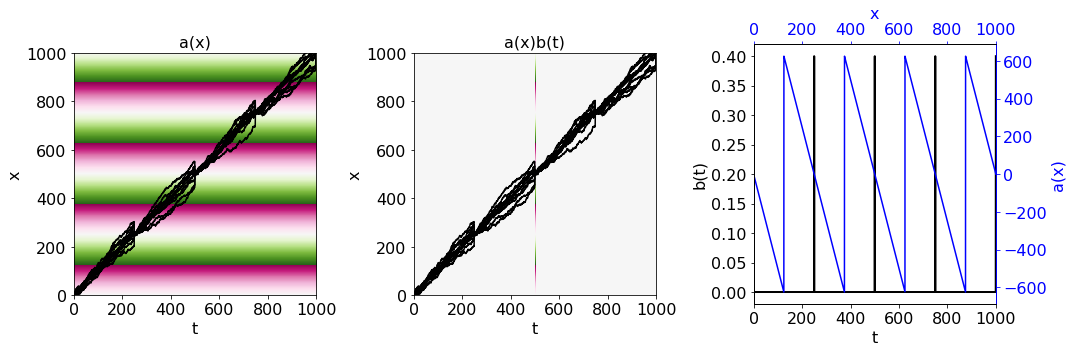

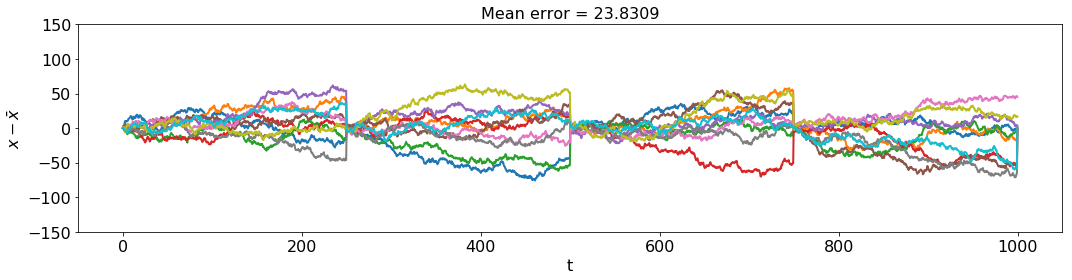

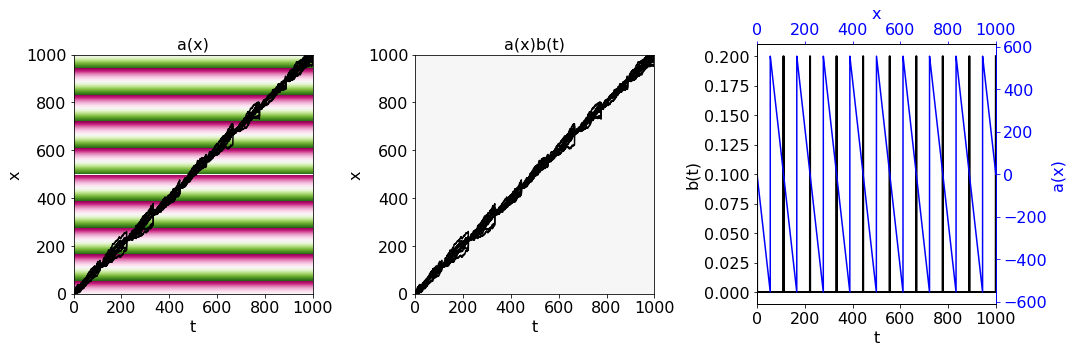

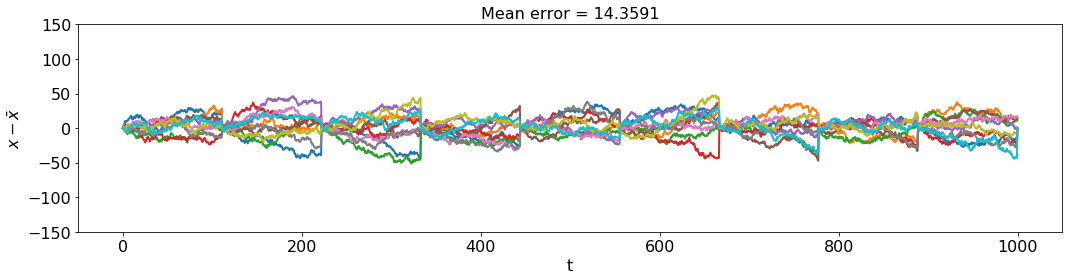

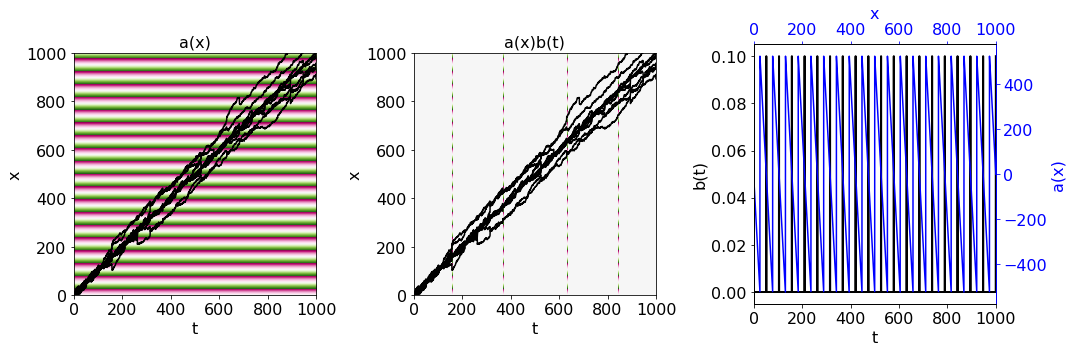

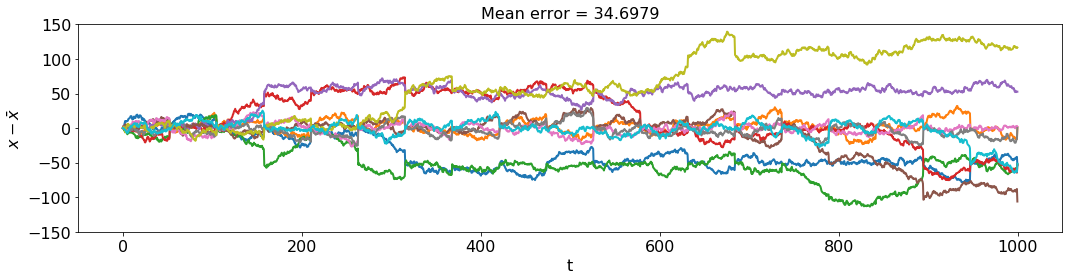

In [3]:
# demo no control vs sawtooth control
def sawtooth(n):
    """Return a sawtooth a and periodic delta-comb b with n delta funcs (including end points)."""
    if n < 2:
        return np.zeros(len(X)), np.zeros(len(T))
    
    it = np.round(np.linspace(T[0], T[-1], n)/DT).astype(int)
    it[-1]
    
    b = np.zeros(len(T))
    b[it] = 1 / (n*DT)
    
    x_itvl = (X_BAR[-1] - X_BAR[0]) / (n - 1)
    
    a = np.zeros(len(X))
    for cit, it_ in enumerate(it):
        mx = (X_BAR[it_] - x_itvl/2 <= X) & (X < X_BAR[it_] + x_itvl/2)
        a[mx] = n*(X_BAR[it_] - X[mx])
    
    return a, b

for n in [0, 3, 5, 10, 20]:
    a, b = sawtooth(n)
    xs = np.transpose([run(a, b, 2, seed=i) for i in range(N_TR)])

    plot_ab(a, b, xs)
    plot_err(xs, y_lim=(-150, 150))